In [110]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log(np.abs(matrix).max()) / np.log(2))

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(np.abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()

## Create dataset
Using [make_blobs](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html), create a few gaussian distributions with different parameters.  make_blobs produces Y=labels, but these aren't used here.

In [111]:
from sklearn.datasets.samples_generator import make_blobs
number_of_sources = 3
X,Y = make_blobs(cluster_std=1.5,
                 random_state=20,
                 n_samples=500,
                 centers=number_of_sources)

Stretch dataset to get ellipsoid data

In [112]:
import numpy as np
X = np.dot(X,np.random.RandomState(0).randn(2,2))
x,y = np.meshgrid(np.sort(X[:,0]), np.sort(X[:,1]))
XY = np.array([x.flatten(),y.flatten()]).T
print(XY)   # list of [x,y] coordinates, in X-major order

[[-20.13247332  -2.68399615]
 [-19.82824612  -2.68399615]
 [-19.48867453  -2.68399615]
 ...
 [ 26.2787897   26.01375851]
 [ 26.43569095  26.01375851]
 [ 26.87243202  26.01375851]]


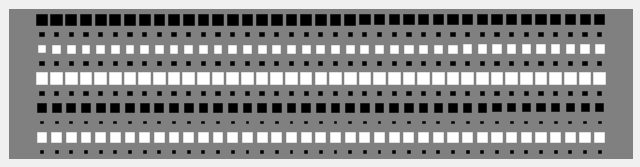

In [113]:
fig = plt.figure(figsize=(10,10))
hinton(np.concatenate([XY[1:40],XY[201:240],XY[401:440],XY[601:640],XY[801:840]],axis=1))

Create a regularizing covariance matrix (what is this used for?)

In [114]:
reg_cov = 1e-6 * np.identity(len(X[0]))
print(reg_cov)  # covariance matrix for the 2-d coordinates

[[1.e-06 0.e+00]
 [0.e+00 1.e-06]]


## Set the initial mu, covariance and pi values

This is an n x m matrix since we assume n sources (n Gaussians) where each has m dimensions

[[ 8 -6]
 [ 1  0]
 [ 7 -3]]


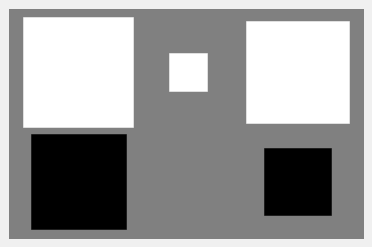

In [137]:
mu = np.random.randint(min(X[:,0])/2, 
                       max(X[:,0])/2, 
                       size=(number_of_sources,len(X[0]))) 
hinton(mu); print(mu)

We need a nxmxm covariance matrix for each source since we have m features 
 * We create symmetric covariance matrices with ones on the digonal

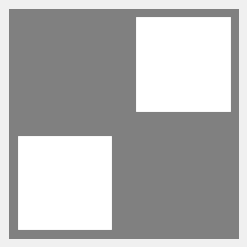

In [133]:
cov = np.zeros((number_of_sources,len(X[0]),len(X[0]))) 
for dim in range(len(cov)):
    np.fill_diagonal(cov[dim],5)
hinton(cov[1,:]); hinton(cov[2,:])

In [134]:
pi = np.ones(number_of_sources)/number_of_sources # Are "Fractions" 
pi

array([0.33333333, 0.33333333, 0.33333333])

In [135]:
log_likelihoods = [] # In this list we store the log likehoods per iteration and plot them in the end to check if
                         # if we have converged

Plot the initial state

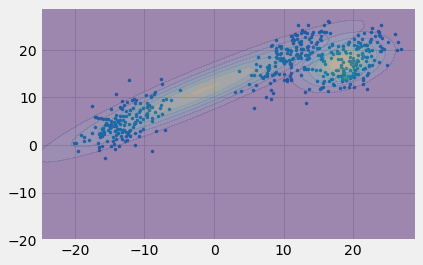

In [173]:
def plotGMM(X,mu_s,cov_s):
    from scipy.stats import multivariate_normal
    plt.figure()
    plt.scatter(X[:,0],X[:,1],marker='.')
    for mu,cov in zip(mu_s,cov_s):
        multi_normal = multivariate_normal(mean=mu,cov=cov)
        x,y=np.mgrid[-25:30:1,-20:30:1]
        z=multi_normal.pdf(np.dstack((x,y)))
        plt.contourf(x,y,z,alpha=0.2)
plotGMM(X,mu,cov)

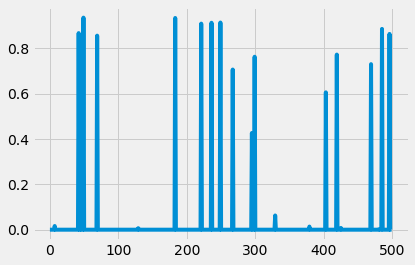

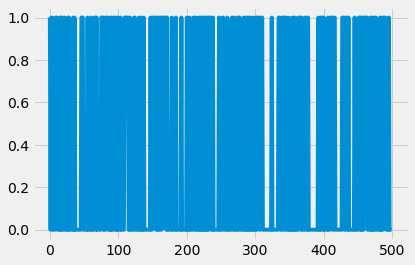

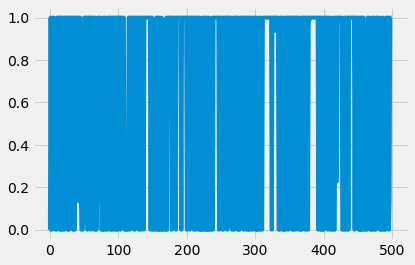

In [238]:
"""E Step"""
r_ic = np.zeros((len(X),len(cov)))
for m, co, p, r in zip(mu, cov, pi, range(len(r_ic[0]))):
    #co += reg_cov   # why is this here?
    mn = multivariate_normal(mean=m,cov=co)
    temp = [pi_c * multivariate_normal(mean=mu_c,cov=cov_c).pdf(X) for pi_c, mu_c, cov_c in zip(pi, mu, cov + reg_cov)]
    r_ic[:,r] = p * mn.pdf(X) /  np.sum(temp,axis=0)
plt.figure(); plt.plot(np.arange(len(X)),r_ic[:,0])
plt.figure(); plt.plot(np.arange(len(X)),r_ic[:,1])
plt.figure(); plt.plot(np.arange(len(X)),r_ic[:,2])

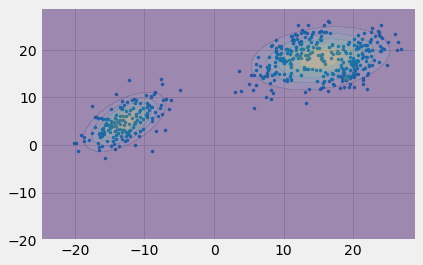

In [239]:
"""M Step"""
# Calculate the new mean vector and new covariance matrices, based on the probable membership of the 
# single x_i to classes c --> r_ic
mu = []
cov = []
pi = []
log_likelihood = []
for c in range(len(r_ic[0])):
    m_c = np.sum(r_ic[:,c],axis=0)
    mu_c = (1/m_c)*np.sum(X*r_ic[:,c].reshape(len(X),1),axis=0)
    mu.append(mu_c)
    # Calculate the covariance matrix per source based on the new mean
    cov.append(((1/m_c)*np.dot((np.array(r_ic[:,c]).reshape(len(X),1)*(X-mu_c)).T,(X-mu_c)))+reg_cov)
    # Calculate pi_new which is the "fraction of points" respectively the fraction of the probability assigned to each source 
    pi.append(m_c/np.sum(r_ic)) 
    # Here np.sum(r_ic) gives as result the number of instances. This is logical since we know 
    # that the columns of each row of r_ic adds up to 1. Since we add up all elements, we sum up all
    # columns per row which gives 1 and then all rows which gives then the number of instances (rows) 
    # in X --> Since pi_new contains the fractions of datapoints, assigned to the sources c,
    # The elements in pi_new must add up to 1
plotGMM(X,mu,cov)

In [128]:
iterations = 1000
for i in range(iterations):            
    """E Step"""
    r_ic = np.zeros((len(X),len(cov)))
    for m, co, p, r in zip(mu, cov, pi, range(len(r_ic[0]))):
        #co += reg_cov   # why is this here?
        mn = multivariate_normal(mean=m,cov=co)
        temp = [pi_c * multivariate_normal(mean=mu_c,cov=cov_c).pdf(X) for pi_c, mu_c, cov_c in zip(pi, mu, cov + reg_cov)]
        r_ic[:,r] = p * mn.pdf(X) /  np.sum(temp,axis=0)

    """M Step"""
    # Calculate the new mean vector and new covariance matrices, based on the probable membership of the 
    # single x_i to classes c --> r_ic
    mu = []
    cov = []
    pi = []
    log_likelihood = []
    for c in range(len(r_ic[0])):
        m_c = np.sum(r_ic[:,c],axis=0)
        mu_c = (1/m_c)*np.sum(X*r_ic[:,c].reshape(len(X),1),axis=0)
        mu.append(mu_c)
        # Calculate the covariance matrix per source based on the new mean
        cov.append(((1/m_c)*np.dot((np.array(r_ic[:,c]).reshape(len(X),1)*(X-mu_c)).T,(X-mu_c)))+reg_cov)
        # Calculate pi_new which is the "fraction of points" respectively the fraction of the probability assigned to each source 
        pi.append(m_c/np.sum(r_ic)) 
        # Here np.sum(r_ic) gives as result the number of instances. This is logical since we know 
        # that the columns of each row of r_ic adds up to 1. Since we add up all elements, we sum up all
        # columns per row which gives 1 and then all rows which gives then the number of instances (rows) 
        # in X --> Since pi_new contains the fractions of datapoints, assigned to the sources c,
        # The elements in pi_new must add up to 1

    """Log likelihood"""
    log_likelihoods.append(np.log(np.sum([k*multivariate_normal(mu[i],cov[j]).pdf(X) for k,i,j in zip(pi,range(len(mu)),range(len(cov)))])))

The above calculation of r_ic is not that obvious I want to quickly derive what we have done above.
### First of all the denominator:
 * We calculate for each source c which is defined by m,co and p for every instance x_i, the multivariate_normal.pdf() value.
 * For each loop this gives us a 100x1 matrix (This value divided by the denominator is then assigned to r_ic[:,r] which is in the end a 100x3 matrix).

### Second the denominator:
What we do here is, we calculate the multivariate_normal.pdf() for every instance x_i for every source c which is defined by pi_c, mu_c, and cov_c and write this into a list. 

This gives us a 3x100 matrix where we have 100 entrances per source c.
Now the formula wants us to add up the pdf() values given by the 3 sources for each x_i. 

Hence we sum up this list over axis=0.

This gives us then a list with 100 entries.

What we have now is FOR EACH LOOP a list with 100 entries in the nominator and a list with 100 entries in the denominator where each element is the pdf per class c for each instance x_i (nominator) respectively the summed pdf's of classes c for each instance x_i.

Consequently we can now divide the nominator by the denominator and have as result a list with 100 elements which we can then assign to r_ic[:,r] --> One row r per source c.

In the end after we have done this for all three sources (three loops) and run from r==0 to r==2 we get a matrix with dimensionallity 100x3 which is exactly what we want.

If we check the entries of r_ic we see that there mostly one element which is much larger than the other two. 

This is because every instance x_i is much closer to one of the three gaussians (that is, much more likely to come from this gaussian) than
it is to the other two.

That is practically speaing, r_ic gives us the fraction of the probability that x_i belongs to class c over the probability that x_i belonges to any of the classes c (Probability that x_i occurs given the 3 Gaussians).


"""
This process of E step followed by a M step is now iterated a number of n times. In the second step for instance,
we use the calculated pi_new, mu_new and cov_new to calculate the new r_ic which are then used in the second M step
to calculat the mu_new2 and cov_new2 and so on....
"""

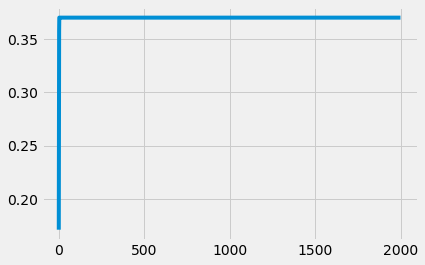

In [129]:
plt.figure()
plt.plot(log_likelihoods)

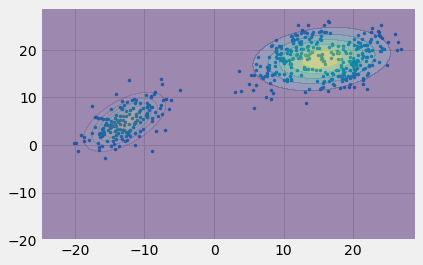

In [130]:
plt.figure()
plt.scatter(X[:,0],X[:,1],marker='.')
for mu_,cov_ in zip(mu,cov):
    multi_normal = multivariate_normal(mean=mu_,cov=cov_)
    x,y=np.mgrid[-25:30:1,-20:30:1]
    z=multi_normal.pdf(np.dstack((x,y)))
    plt.contourf(x,y,z,alpha=0.2)